In [5]:
from src import *

## Description

Comparing aligned gradient's centroid and concentration and their evolution over time versus item timeseries

GOAL: Item timeseries correlation / metrics against centroid and concentration timeseries

## Table of Contents
- [Timeseries Comparison](#comparison)

<a class="anchor" id="comparison"></a>
### Timeseries Comparison 
Comparison between item timeseries and centroid of region timeseries

Movie name used for gradient: `'TC_400_sub-S09_ses-4_Sintel.csv'`

In [20]:
# Loading Gradient Example
mri_path = "./data/fmri_compile.csv"
weight_path = "./resources/gradient_movie_ws140.npy"
mri_df   = pd.read_csv(mri_path)
G_movie  = np.load(weight_path)

# Loading Matching Emotion Track
emo_df = pd.read_csv('./data/emotion_compile.csv')
emo_df = emo_df[emo_df['filename']=='W_Sintel13.csv']

In [25]:
index2region = load('./resources/yeo7region400.pkl')

Text(0.5, 0.98, 'Movie Gradient 1: region centroids position shift and concentration')

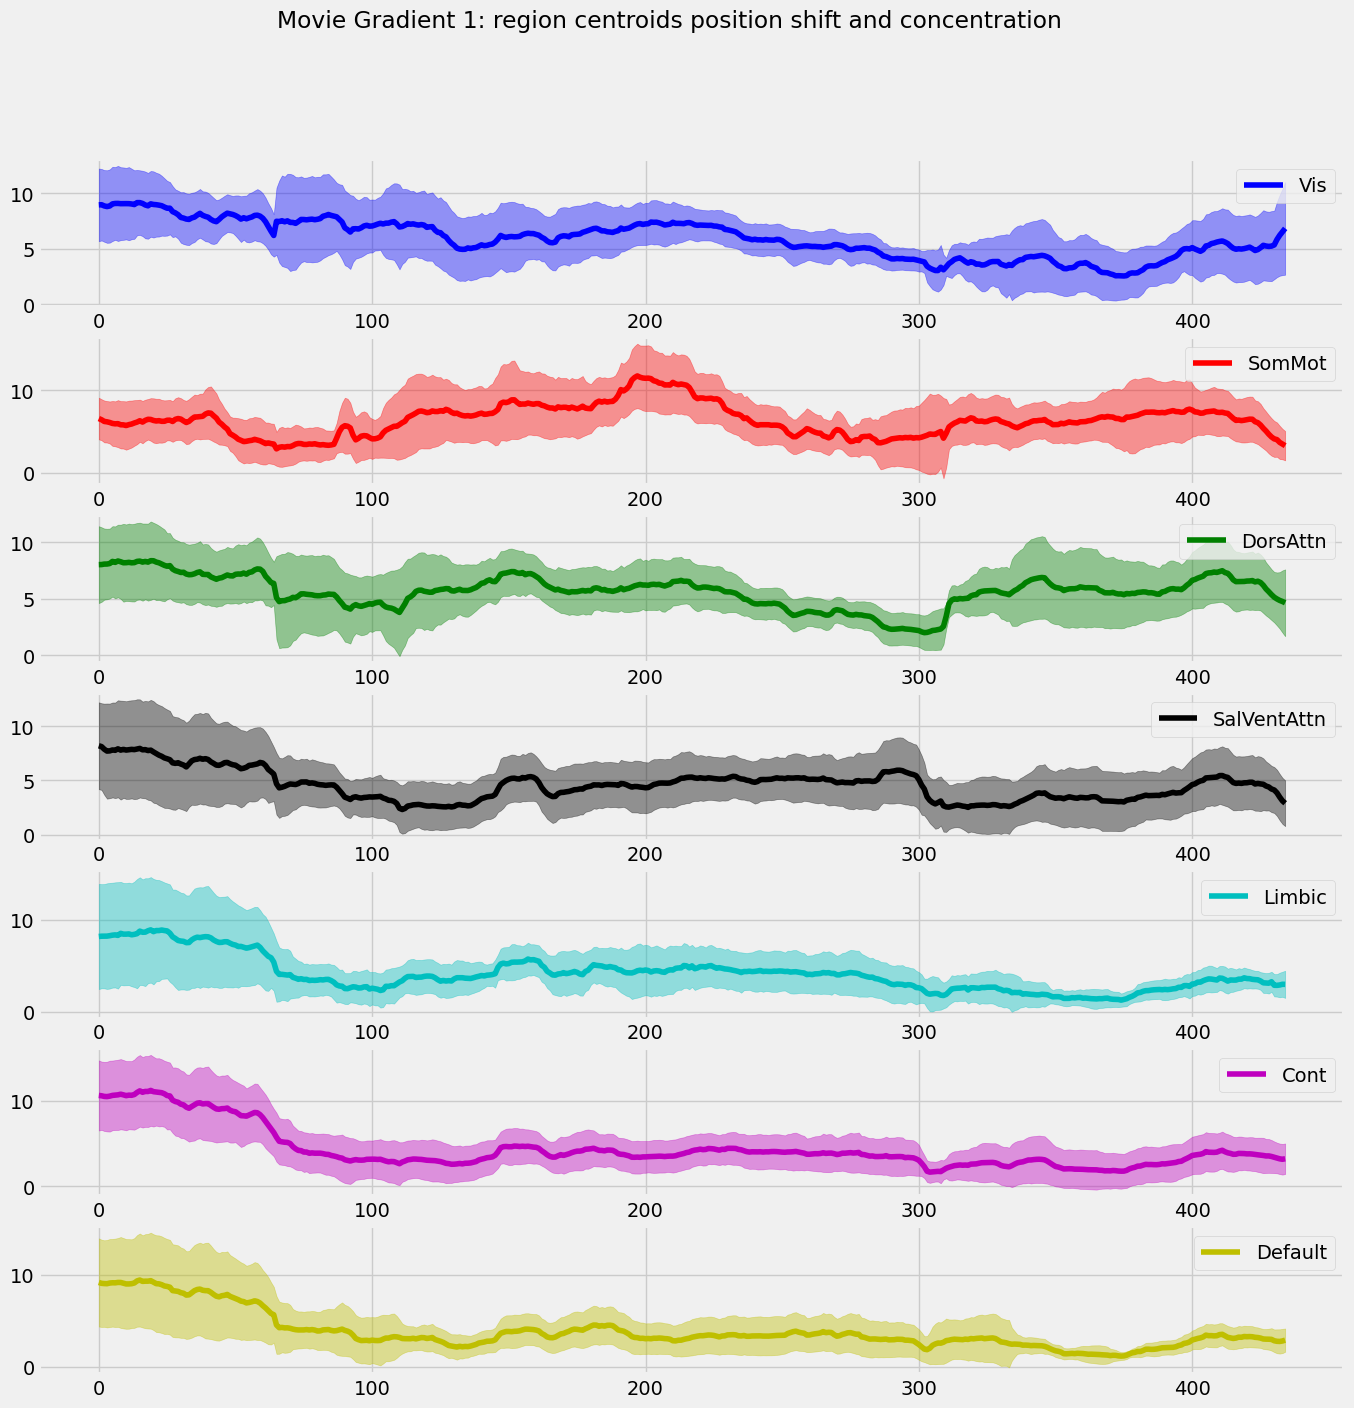

In [27]:
n = len(mri_df.partial_region.unique())
fig, ax = plt.subplots(n,1,figsize=(15,15))
grad_idx = 0
for idx, R in enumerate(mri_df.partial_region.unique()):
    y = np.abs(G_movie[:,index2region[R]]).mean(axis=1)[:,grad_idx]
    x = np.arange(len(y))
    error = np.abs(G_movie[:,index2region[R]]).std(axis=1)[:,grad_idx]

    ax[idx].plot(x,y, color=PALETTE[idx], label=R)
    ax[idx].fill_between(x, y-error, y+error, color=PALETTE[idx], alpha=0.4)
    ax[idx].legend()
    # ax[idx].set_ylim(0, 30)
plt.suptitle("Movie Gradient {}: region centroids position shift and concentration".format(grad_idx + 1))

Text(0.5, 0.98, 'Movie Gradient 1: region concentration')

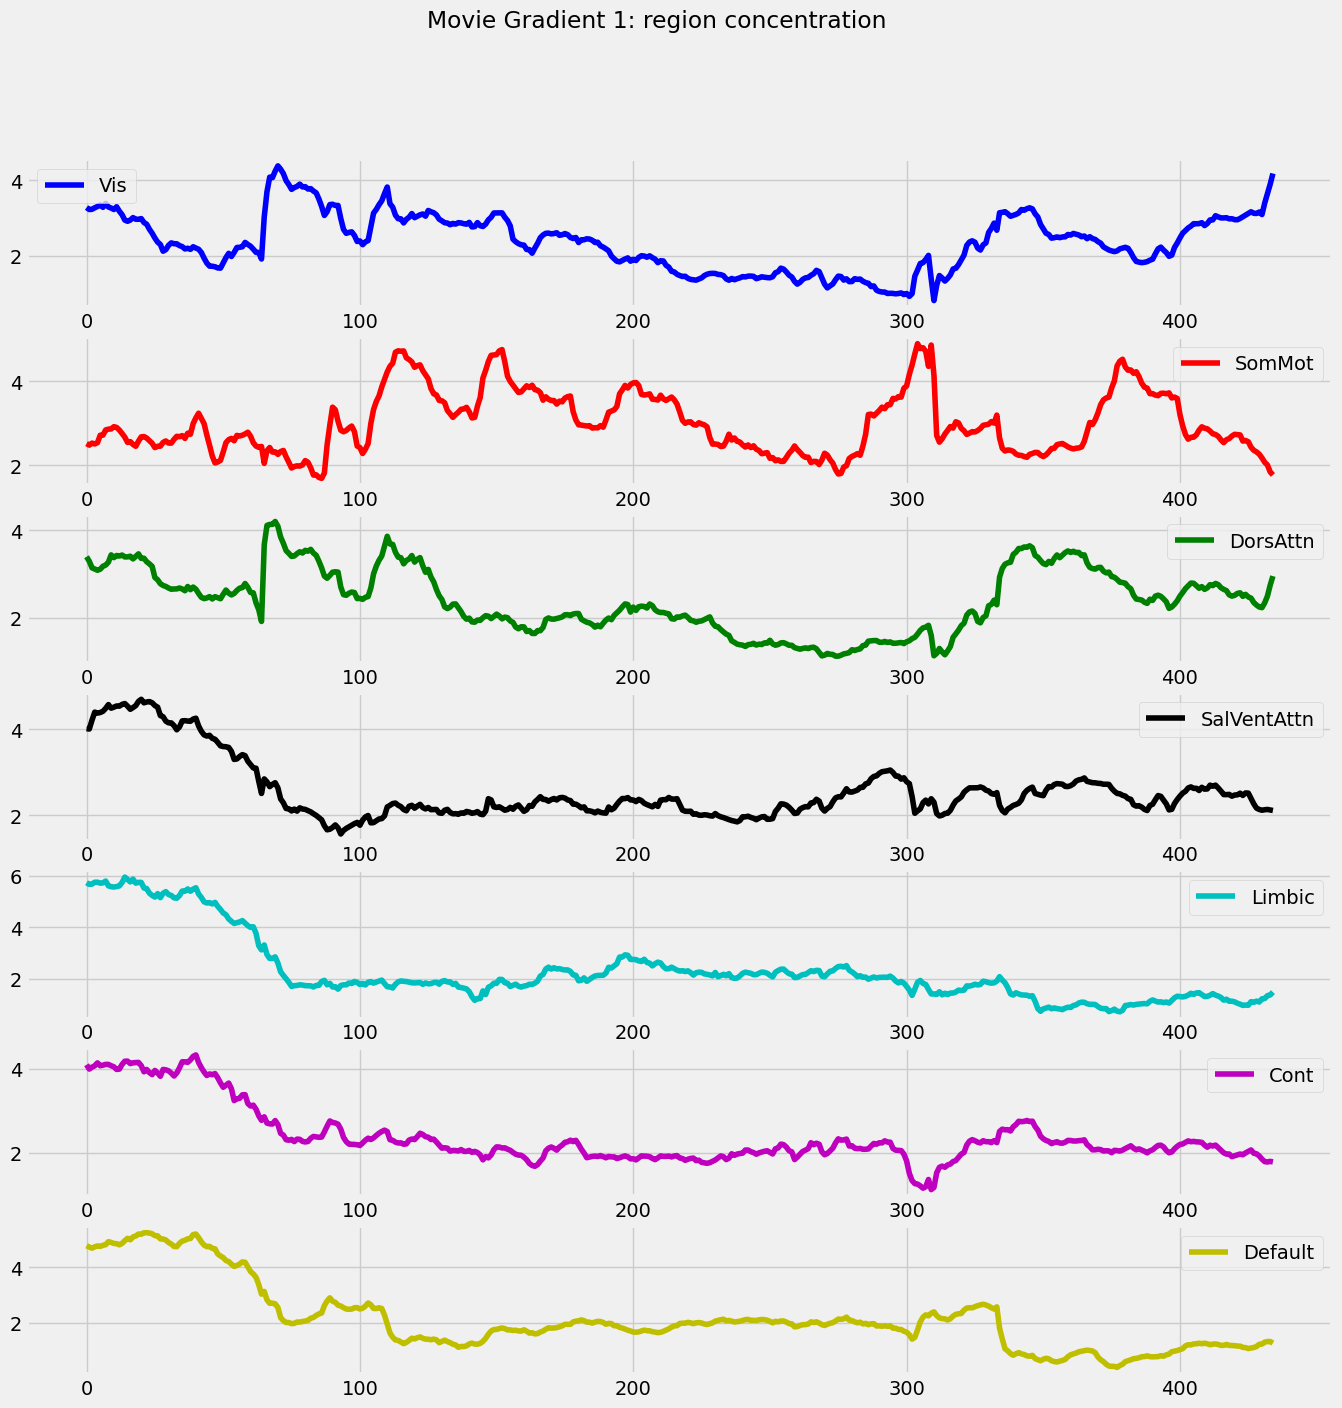

In [49]:
n = len(mri_df.partial_region.unique())
fig, ax = plt.subplots(n,1,figsize=(15,15))
grad_idx = 0
for idx, R in enumerate(mri_df.partial_region.unique()):
    y = np.abs(G_movie[:,index2region[R]]).std(axis=1)[:,grad_idx]
    x = np.arange(len(y))
    ax[idx].plot(x,y, color=PALETTE[idx], label=R)
    ax[idx].legend()
    # ax[idx].set_ylim(0, 30)
plt.suptitle("Movie Gradient {}: region concentration".format(grad_idx + 1))

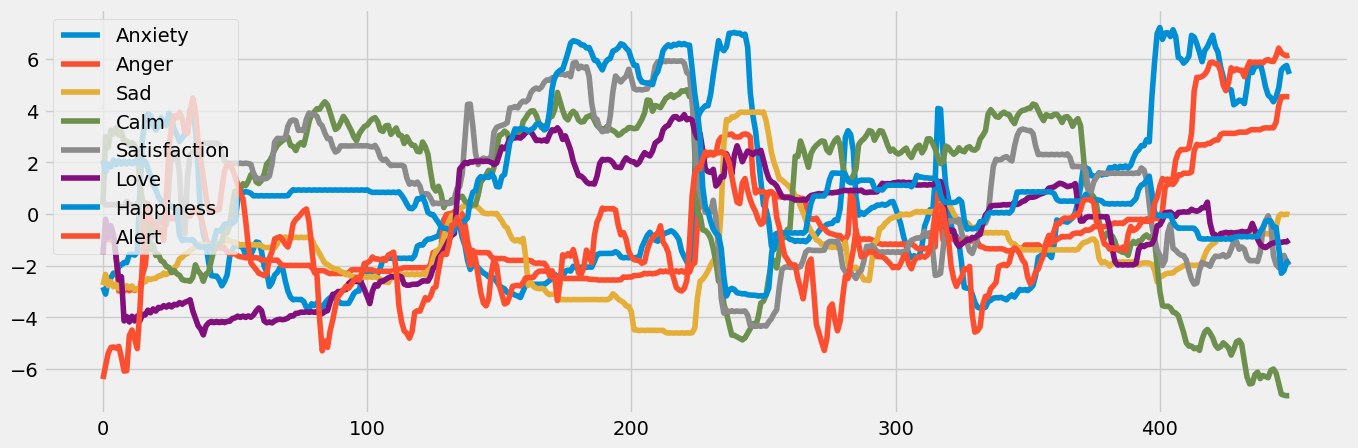

In [184]:
# emotions = "Interest, Joy, Surprise, Sadness, Anger, Disgust, Contempt, Self-Hostility, Fear, Shame, Shyness, Guilt".split(',')
select   = ["Anxiety", "Anger", "Sad",  "Calm", "Satisfaction",  "Love", "Happiness", "Alert"]

plt.figure(figsize=(15,5))
for emotion in select:
    emo_series = np.array(emo_df[emo_df.item==emotion]['score'])[:450]
    plt.plot(emo_series, label=emotion)

plt.legend()

In [174]:
# Grid for each region of correlation with items

grad_idx = 0
select   = ["Anxiety", "Anger", "Sad",  "Calm", "Satisfaction",  "Love", "Happiness", "Alert"]
regions  = mri_df.partial_region.unique()
smfactor = 1
tolshift = 0

n = len(regions)
m = len(select)

scores = np.zeros((n,m))

for idx, R in enumerate(regions):
    # Metric we use here would be variance of a cluster
    # y = np.abs(G_movie[:,index2region[R]]).std(axis=1)[:,grad_idx]
    y = np.abs(G_movie[:,index2region[R]]).mean(axis=1)[:,grad_idx]
    z1 = zscore(y)

    for jdx, emotion in enumerate(select):
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        corr = correlation_search(z1,z2, tolshift)
        scores[idx,jdx] = corr

We select here the max and visualize how well they correlate each other

In [175]:
scores.max(), scores.argmax(), scores.argmax()//m, scores.argmax()%m

(0.5764262456356524, 14, 1, 6)

In [182]:
a = np.abs(G_movie[:,index2region[regions[1]]]).mean(axis=1)[:,grad_idx]
b = np.array(emo_df[emo_df.item==select[6]]['score'])
b = overlap_add(b, 1)

a, b = zscore(a), zscore(b)
correlation_search(a,b[:a.shape[0]], 0, 1)

(0.5764262456356523, (0, 0), 7.033996516642822e-40)

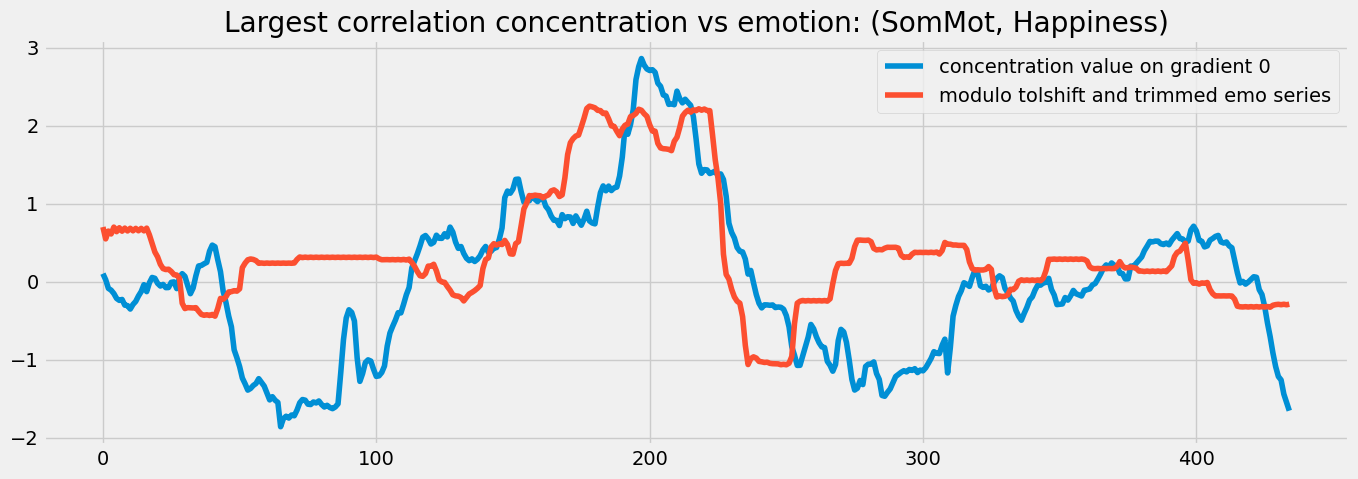

In [183]:
plt.figure(figsize=(15,5))
plt.plot(a, label='concentration value on gradient {}'.format(grad_idx))
plt.plot(b[:a.shape[0]], label='modulo tolshift and trimmed emo series')
plt.title("Largest correlation concentration vs emotion: ({}, {})".format(regions[1],select[6]))
plt.legend()

Distance between regions on gradients

0.32886136379486963
11.147343251319477


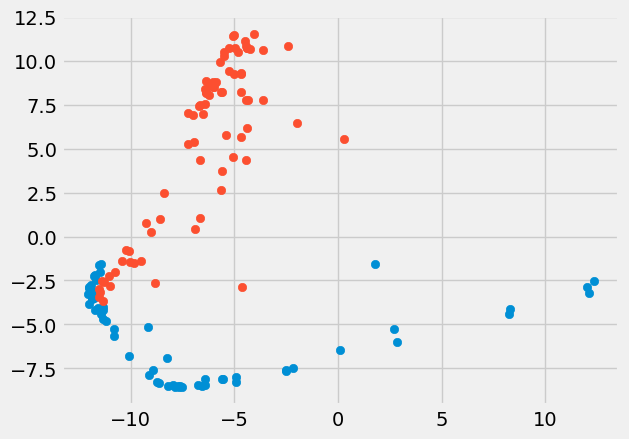

In [210]:
c1 = G_movie[0,index2region[regions[0]]]
c2 = G_movie[0,index2region[regions[1]]]

plt.scatter(c1[:,0], c1[:,1])
plt.scatter(c2[:,0], c2[:,1])

print(cluster_distance(c1,c2))
print(cluster_distance(c1,c2, method="centroid"))

In [207]:
regions

array(['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont',
       'Default'], dtype=object)

In [208]:
T = G_movie.shape[0]
C = np.zeros((T, n, n))
for t in tqdm(range(T)):
    for i, r1 in enumerate(regions):
        for j, r2 in enumerate(regions):
            c1 = G_movie[t, index2region[r1]]
            c2 = G_movie[t, index2region[r2]]
            C[t,i,j] = cluster_distance(c1,c2)

100%|██████████| 435/435 [02:47<00:00,  2.60it/s]


In [216]:
T = G_movie.shape[0]
C2 = np.zeros((T, n, n))
for t in tqdm(range(T)):
    for i, r1 in enumerate(regions):
        for j, r2 in enumerate(regions):
            c1 = G_movie[t, index2region[r1]]
            c2 = G_movie[t, index2region[r2]]
            C2[t,i,j] = cluster_distance(c1,c2, method="centroid")

100%|██████████| 435/435 [00:00<00:00, 883.73it/s]


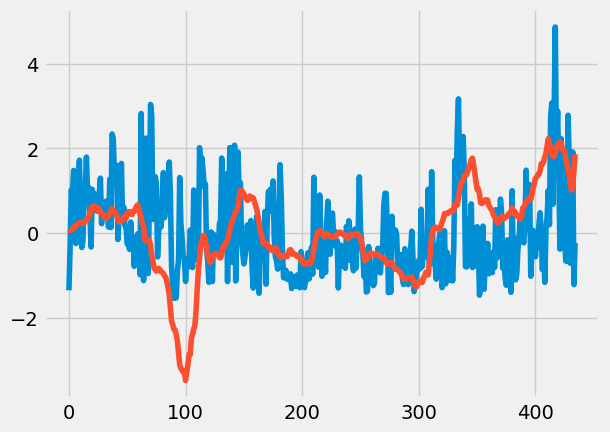

In [222]:
plt.plot(zscore(C[:,2,-1]))
plt.plot(zscore(C2[:,2,-1]))

Heat map of motion of regions

In [226]:
G_movie[:, index2region[r1]][:,0]

array([[ 4.76679213e-01,  9.53281163e+00],
       [ 4.98091173e-01,  9.25841980e+00],
       [ 5.35148823e-01,  9.27410798e+00],
       [ 7.52342649e-01,  9.09130003e+00],
       [ 7.21426364e-01,  9.00306927e+00],
       [ 8.71248197e-01,  9.15176557e+00],
       [ 8.86790819e-01,  9.18049369e+00],
       [ 7.77071700e-01,  9.22516838e+00],
       [ 8.55494977e-01,  9.38707083e+00],
       [ 6.24273979e-01,  9.67429068e+00],
       [ 5.21193963e-01,  9.77213636e+00],
       [ 5.77443322e-01,  9.74050198e+00],
       [ 4.44167749e-01,  9.73271222e+00],
       [ 3.84421306e-01,  9.59854771e+00],
       [ 1.71227894e-01,  9.81383453e+00],
       [ 3.66698261e-02,  9.87865137e+00],
       [-1.42368127e-01,  1.00496346e+01],
       [-1.29072370e-02,  1.03210057e+01],
       [ 1.21049584e-01,  1.05637504e+01],
       [ 2.52273330e-01,  1.09344128e+01],
       [ 2.41889469e-01,  1.15348728e+01],
       [ 2.74906001e-01,  1.19934315e+01],
       [ 2.20411223e-01,  1.23697276e+01],
       [ 1.